In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [3]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

# Carregamento dos dados

In [4]:
try:
    clima_df = pd.read_csv(r'data/clima_recife_2021.csv', parse_dates=['data'])
    dengue_df = pd.read_csv(r"data/dengue_recife_2021.csv", sep=';', encoding='ISO-8859-1', low_memory=False)
except FileNotFoundError as e:
    print(f"Erro ao carregar o arquivo: {e}")

# Pré-processamento dos dados climáticos

In [6]:
if not clima_df.empty:
    clima_df.rename(columns={
        'precipitacao': 'precipitacao_mm',
        'temperatura': 'temp_media_c',
        'umidade': 'umidade_rel_media_pct',
        'vento': 'vento_vel_media_ms'
    }, inplace=True)

    # Agrupar dados horários em dados diários
    # Para temperatura, umidade e vento, usamos a média. Para precipitação, a soma.
    clima_diario_df = clima_df.groupby('data').agg({
        'precipitacao_mm': 'sum',
        'temp_media_c': 'mean',
        'umidade_rel_media_pct': 'mean',
        'vento_vel_media_ms': 'mean'
    }).reset_index()

    # Garantir que não há dias faltando no período. Se houver, preenche com o valor anterior.
    clima_diario_df.set_index('data', inplace=True)
    idx_completo = pd.date_range(start=clima_diario_df.index.min(), end=clima_diario_df.index.max(), freq='D')
    clima_diario_df = clima_diario_df.reindex(idx_completo).fillna(method='ffill')
    
    print("Dados climáticos agregados por dia:")
    print(clima_diario_df.head())

Dados climáticos agregados por dia:
            precipitacao_mm  temp_media_c  umidade_rel_media_pct  \
2021-01-01              0.0        28.900              64.800000   
2021-01-02              0.0        27.625              72.958333   
2021-01-03              0.0        27.500              70.333333   
2021-01-04              0.0        28.375              75.458333   
2021-01-05              0.0        27.250              68.875000   

            vento_vel_media_ms  
2021-01-01                5.04  
2021-01-02                7.20  
2021-01-03                7.05  
2021-01-04               10.20  
2021-01-05                4.20  


C:\Users\vini1\AppData\Local\Temp\ipykernel_26360\2332616001.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  clima_diario_df = clima_diario_df.reindex(idx_completo).fillna(method='ffill')


# Pré-processamento dos dados de Dengue

In [8]:
if not dengue_df.empty:
    # Códigos que representam casos confirmados de Dengue
    # metadados do SINAN: 10-Dengue, 11-Dengue com Sinais de Alarme, 12-Dengue Grave
    casos_confirmados_cod = [10, 11, 12]
    
    # Filtrar apenas os casos confirmados
    dengue_confirmados_df = dengue_df[dengue_df['CLASSI_FIN'].isin(casos_confirmados_cod)].copy()
    
    # Converter a data de notificação para o formato datetime
    # O formato original é 'dd/mm/AAAA'
    dengue_confirmados_df['data'] = pd.to_datetime(dengue_confirmados_df['DT_NOTIFIC'], format='%d/%m/%Y')
    
    # Contar o número de casos por dia
    casos_por_dia = dengue_confirmados_df.groupby('data').size().reset_index(name='casos_dengue')
    casos_por_dia.set_index('data', inplace=True)
    
    print("Dados de dengue agregados por dia:")
    print(casos_por_dia.head())

Dados de dengue agregados por dia:
            casos_dengue
data                    
2021-01-01             4
2021-01-02             2
2021-01-03             1
2021-01-04             3
2021-01-05             9


# União dos DataFrames

In [9]:
if not clima_df.empty and not dengue_df.empty:
    # 'left' para manter todos os dias do dataset de clima.
    # Dias sem notificação de dengue terão o valor NaN, que preenchemos com 0.
    df_combinado = clima_diario_df.join(casos_por_dia, how='left').fillna(0)
    
    print("Dataset combinado:")
    print(df_combinado.head())

Dataset combinado:
            precipitacao_mm  temp_media_c  umidade_rel_media_pct  \
2021-01-01              0.0        28.900              64.800000   
2021-01-02              0.0        27.625              72.958333   
2021-01-03              0.0        27.500              70.333333   
2021-01-04              0.0        28.375              75.458333   
2021-01-05              0.0        27.250              68.875000   

            vento_vel_media_ms  casos_dengue  
2021-01-01                5.04           4.0  
2021-01-02                7.20           2.0  
2021-01-03                7.05           1.0  
2021-01-04               10.20           3.0  
2021-01-05                4.20           9.0  


# Visualização Exploratória

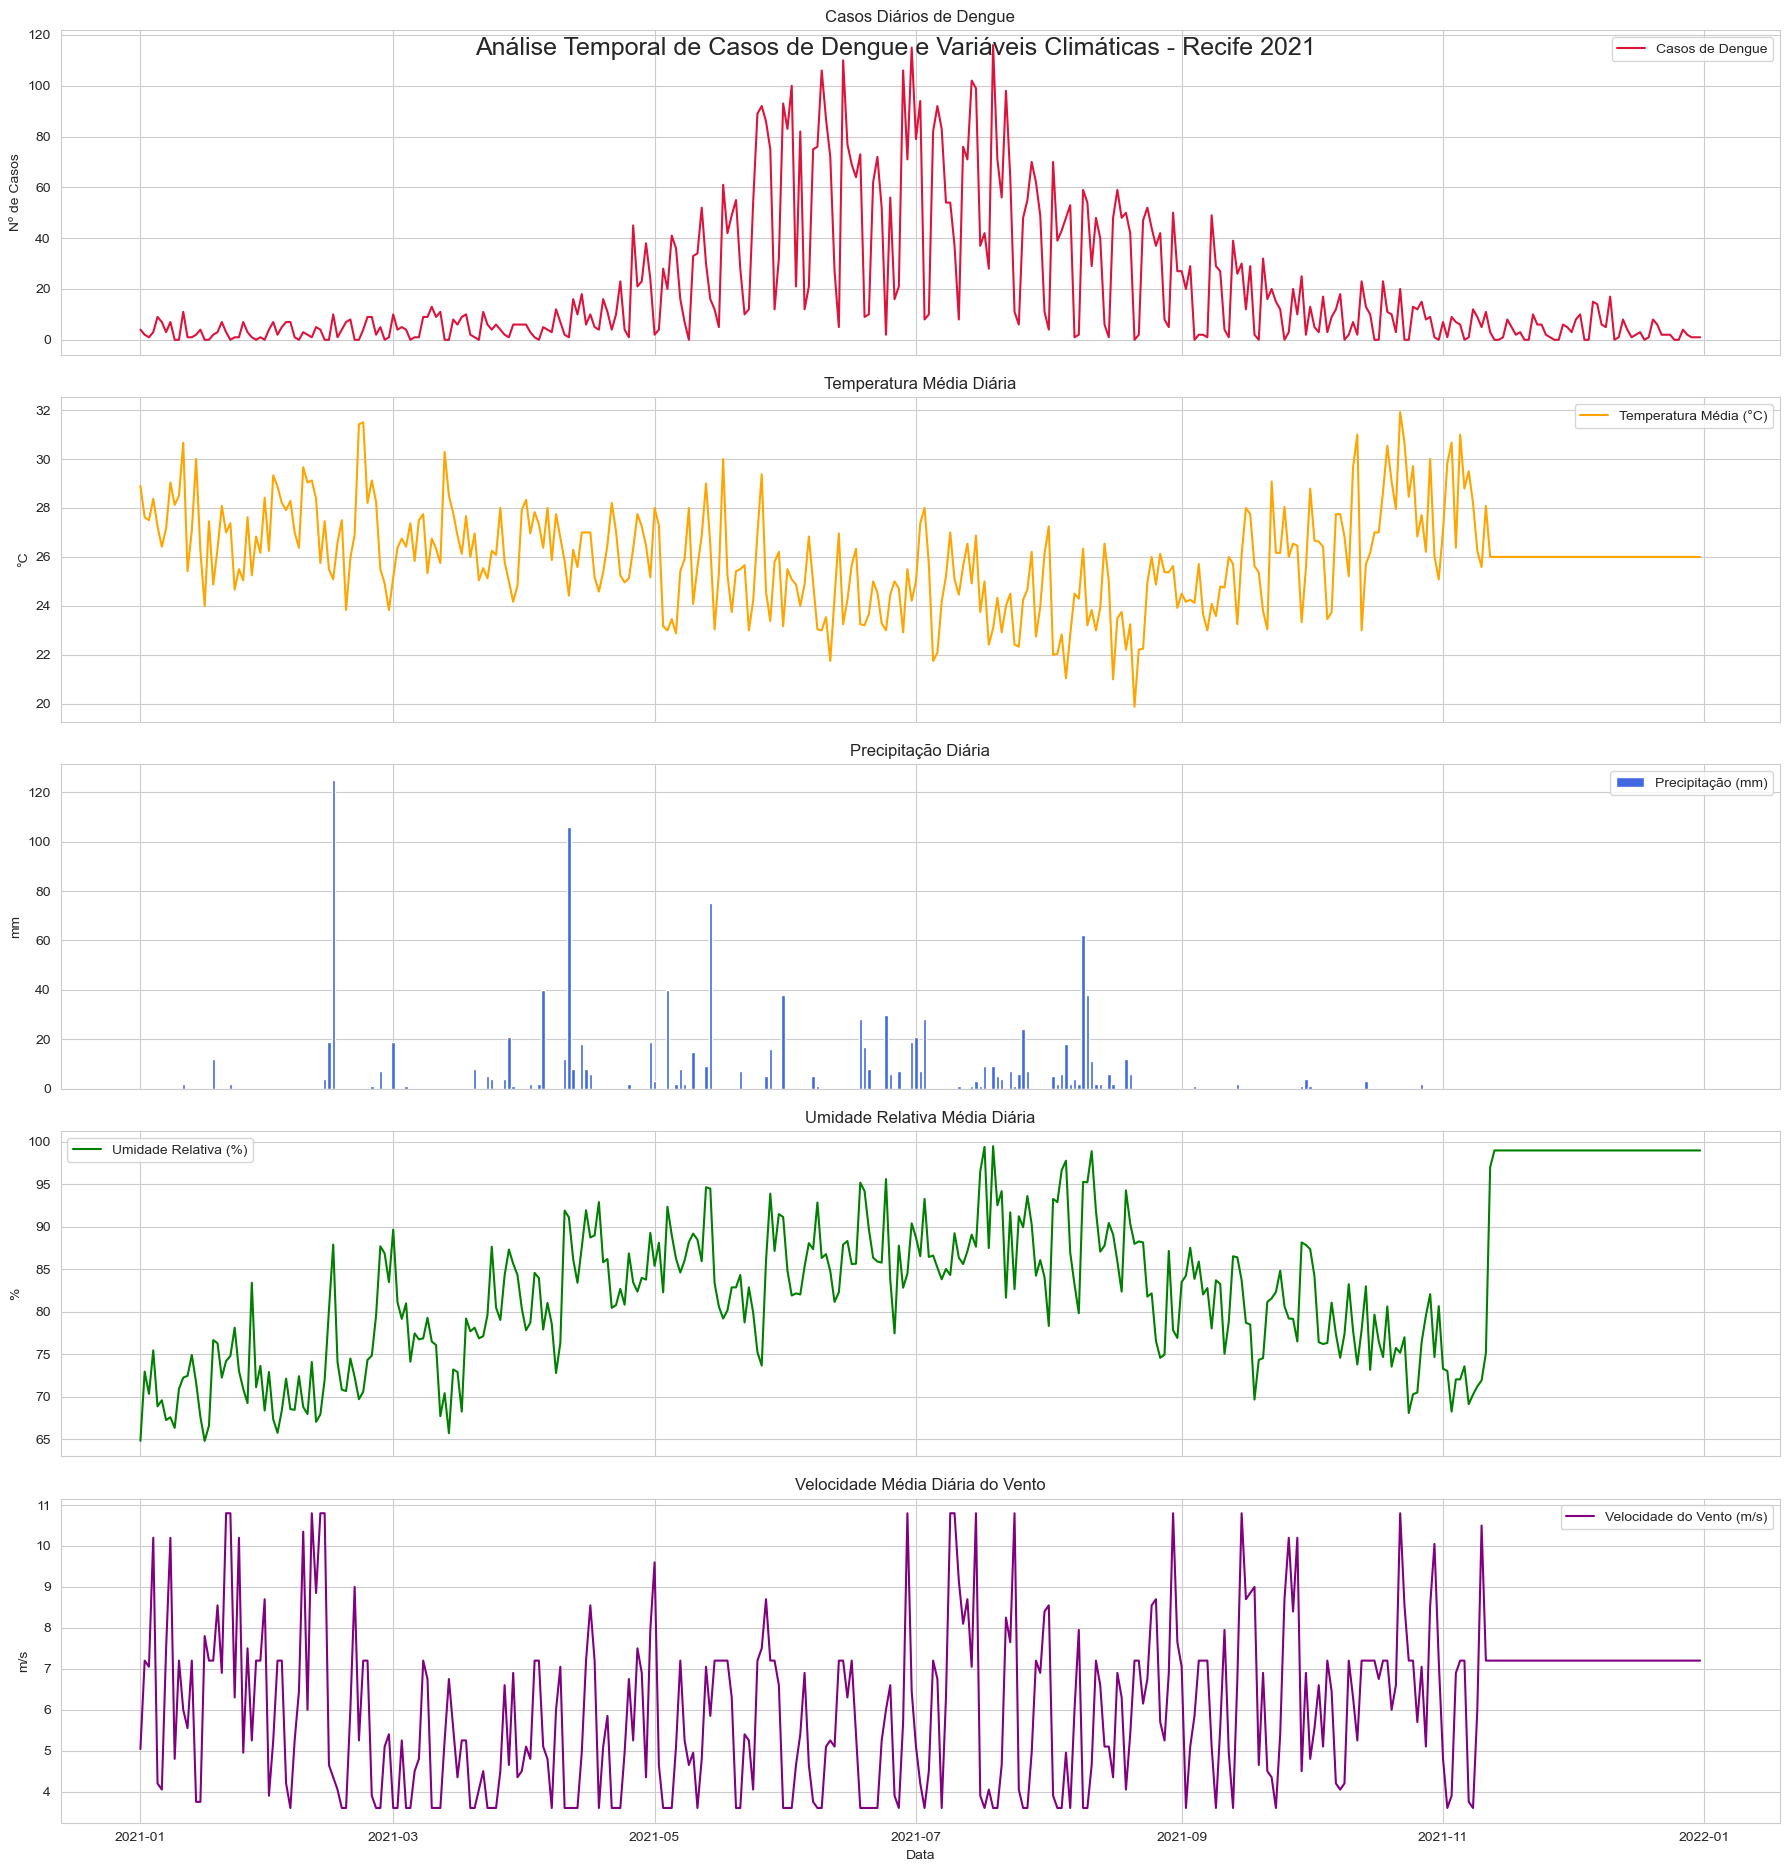

In [10]:
fig, axes = plt.subplots(5, 1, figsize=(18, 20), sharex=True)
fig.suptitle('Análise Temporal de Casos de Dengue e Variáveis Climáticas - Recife 2021', fontsize=18, y=0.92)

# Casos de Dengue
axes[0].plot(df_combinado.index, df_combinado['casos_dengue'], label='Casos de Dengue', color='crimson')
axes[0].set_ylabel('Nº de Casos')
axes[0].set_title('Casos Diários de Dengue')
axes[0].legend()

# Temperatura
axes[1].plot(df_combinado.index, df_combinado['temp_media_c'], label='Temperatura Média (°C)', color='orange')
axes[1].set_ylabel('°C')
axes[1].set_title('Temperatura Média Diária')
axes[1].legend()

# Precipitação
axes[2].bar(df_combinado.index, df_combinado['precipitacao_mm'], label='Precipitação (mm)', color='royalblue')
axes[2].set_ylabel('mm')
axes[2].set_title('Precipitação Diária')
axes[2].legend()

# Umidade
axes[3].plot(df_combinado.index, df_combinado['umidade_rel_media_pct'], label='Umidade Relativa (%)', color='green')
axes[3].set_ylabel('%')
axes[3].set_title('Umidade Relativa Média Diária')
axes[3].legend()

# Vento
axes[4].plot(df_combinado.index, df_combinado['vento_vel_media_ms'], label='Velocidade do Vento (m/s)', color='purple')
axes[4].set_ylabel('m/s')
axes[4].set_title('Velocidade Média Diária do Vento')
axes[4].legend()

plt.xlabel('Data')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Engenharia de Features (atributos)

Dataset final com novos atributos:
            precipitacao_mm  temp_media_c  umidade_rel_media_pct  \
2021-02-12              0.0     25.750000              67.916667   
2021-02-13              4.0     27.458333              72.000000   
2021-02-14             19.0     25.500000              80.208333   
2021-02-15            125.0     25.083333              87.916667   
2021-02-16              0.0     26.583333              74.083333   

            vento_vel_media_ms  casos_dengue  precipitacao_mm_lag_7d  \
2021-02-12               10.80           4.0                     0.0   
2021-02-13               10.80           0.0                     0.0   
2021-02-14                4.65           0.0                     0.0   
2021-02-15                4.35          10.0                     0.0   
2021-02-16                4.05           1.0                     0.0   

            precipitacao_mm_lag_14d  precipitacao_mm_lag_21d  \
2021-02-12                      0.0                      2.

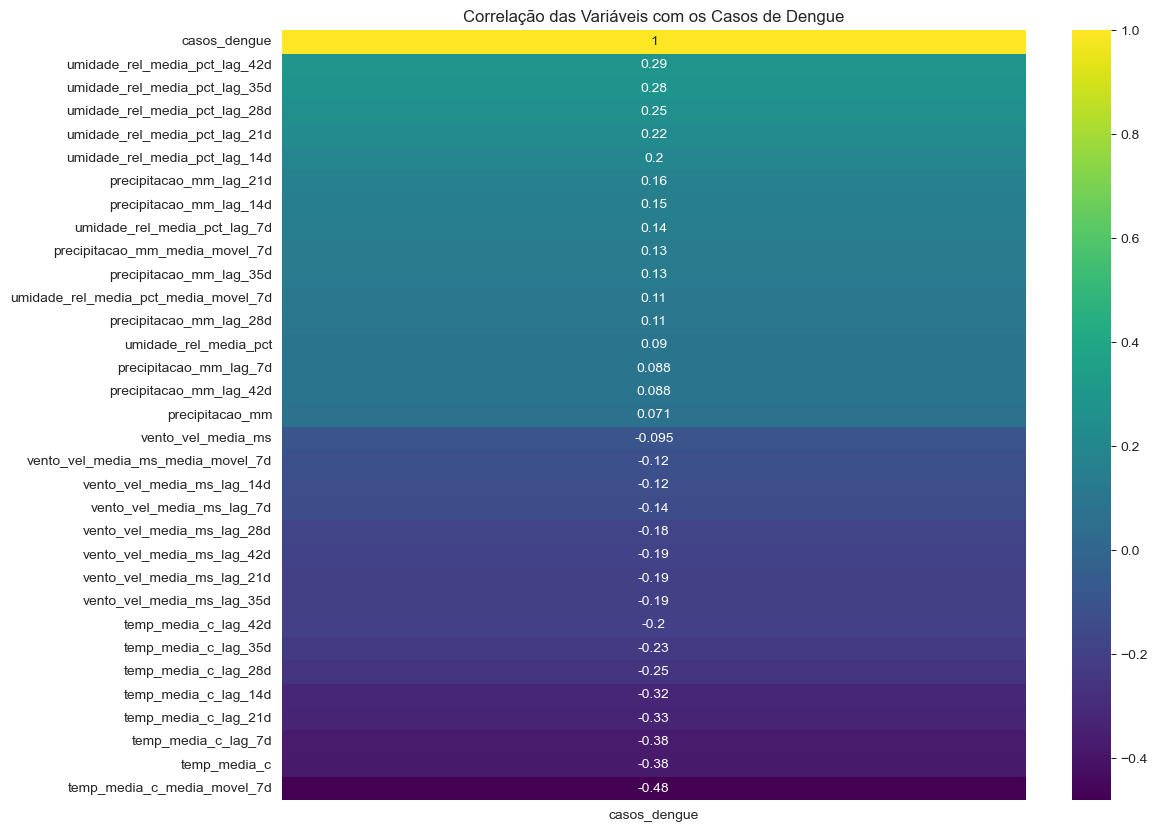

In [11]:
# Criando lags. O ciclo de vida do mosquito e incubação do vírus sugere lags de semanas.
# Vamos usar lags de 1 a 6 semanas (7 a 42 dias)
variaveis_clima = ['precipitacao_mm', 'temp_media_c', 'umidade_rel_media_pct', 'vento_vel_media_ms']
for var in variaveis_clima:
    for lag_dias in [7, 14, 21, 28, 35, 42]:
        df_combinado[f'{var}_lag_{lag_dias}d'] = df_combinado[var].shift(lag_dias)
        
# médias móveis para suavizar os dados climáticos
for var in variaveis_clima:
    df_combinado[f'{var}_media_movel_7d'] = df_combinado[var].rolling(window=7).mean()

# Remover as linhas com NaN geradas pelos lags e médias móveis
df_final = df_combinado.dropna()

print("Dataset final com novos atributos:")
print(df_final.head())

# Visualizar correlação
plt.figure(figsize=(12, 10))
sns.heatmap(df_final.corr()[['casos_dengue']].sort_values(by='casos_dengue', ascending=False), annot=True, cmap='viridis')
plt.title('Correlação das Variáveis com os Casos de Dengue')
plt.show()

# Construção e Treinamento do modelo

In [12]:
y = df_final['casos_dengue']
# As features são todas as outras colunas (climáticas, lags, médias móveis)
X = df_final.drop('casos_dengue', axis=1)

tamanho_treino = int(len(X) * 0.8)
X_treino, X_teste = X[:tamanho_treino], X[tamanho_treino:]
y_treino, y_teste = y[:tamanho_treino], y[tamanho_treino:]

print(f"Tamanho do conjunto de treino: {len(X_treino)} dias")
print(f"Tamanho do conjunto de teste: {len(X_teste)} dias")

# modelo RandomForestRegressor
modelo = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
modelo.fit(X_treino, y_treino)

Tamanho do conjunto de treino: 258 dias
Tamanho do conjunto de teste: 65 dias


RandomForestRegressor(n_jobs=-1, random_state=42)

# Avaliação do Modelo

RMSE (Root Mean Squared Error): 14.60
MAE (Mean Absolute Error): 12.76


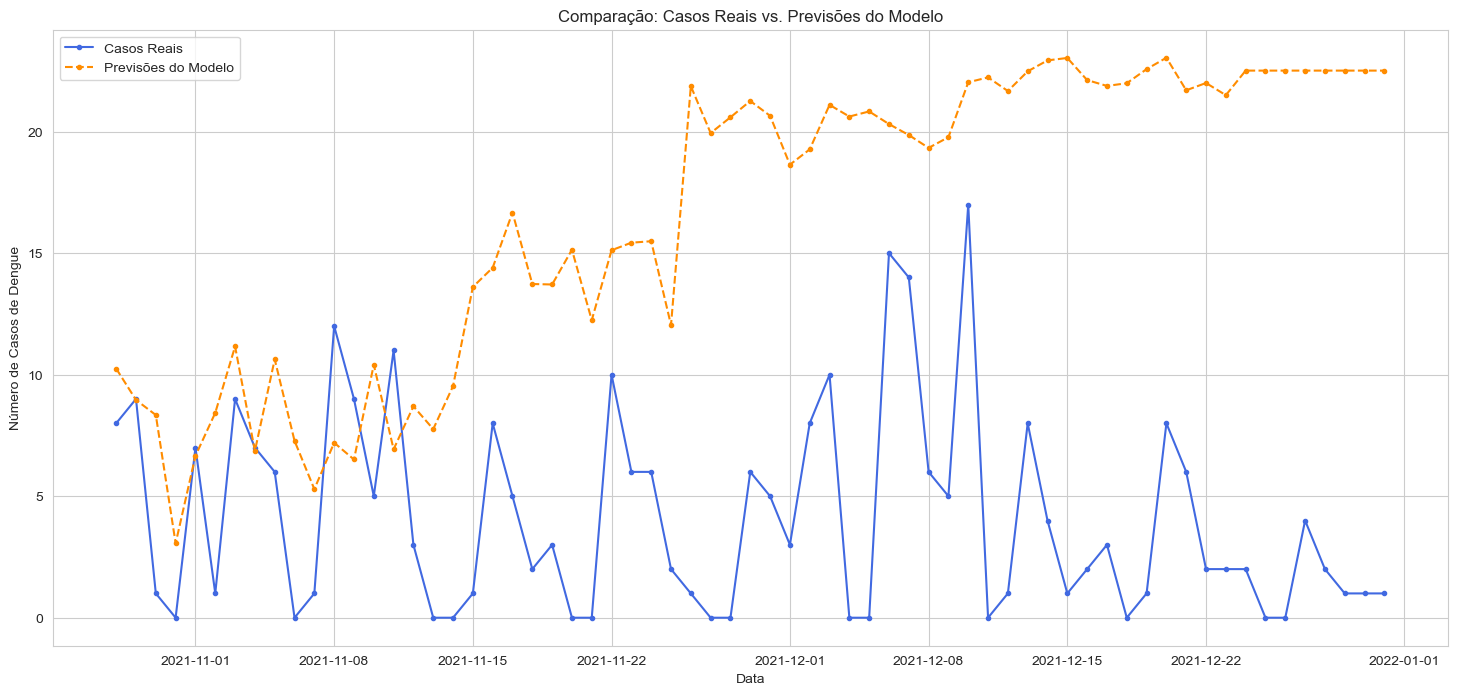

In [13]:
previsoes = modelo.predict(X_teste)

# Calcular as métricas de erro
rmse = np.sqrt(mean_squared_error(y_teste, previsoes))
mae = mean_absolute_error(y_teste, previsoes)
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAE (Mean Absolute Error): {mae:.2f}")


# Plotar os resultados (real vs. previsto)
plt.figure(figsize=(18, 8))
plt.plot(y_teste.index, y_teste, label='Casos Reais', color='royalblue', marker='.', linestyle='-')
plt.plot(y_teste.index, previsoes, label='Previsões do Modelo', color='darkorange', marker='.', linestyle='--')
plt.title('Comparação: Casos Reais vs. Previsões do Modelo')
plt.xlabel('Data')
plt.ylabel('Número de Casos de Dengue')
plt.legend()
plt.show()

## Importância dos atributos

C:\Users\vini1\AppData\Local\Temp\ipykernel_26360\1278091523.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importancias_top10, y=importancias_top10.index, palette='mako')


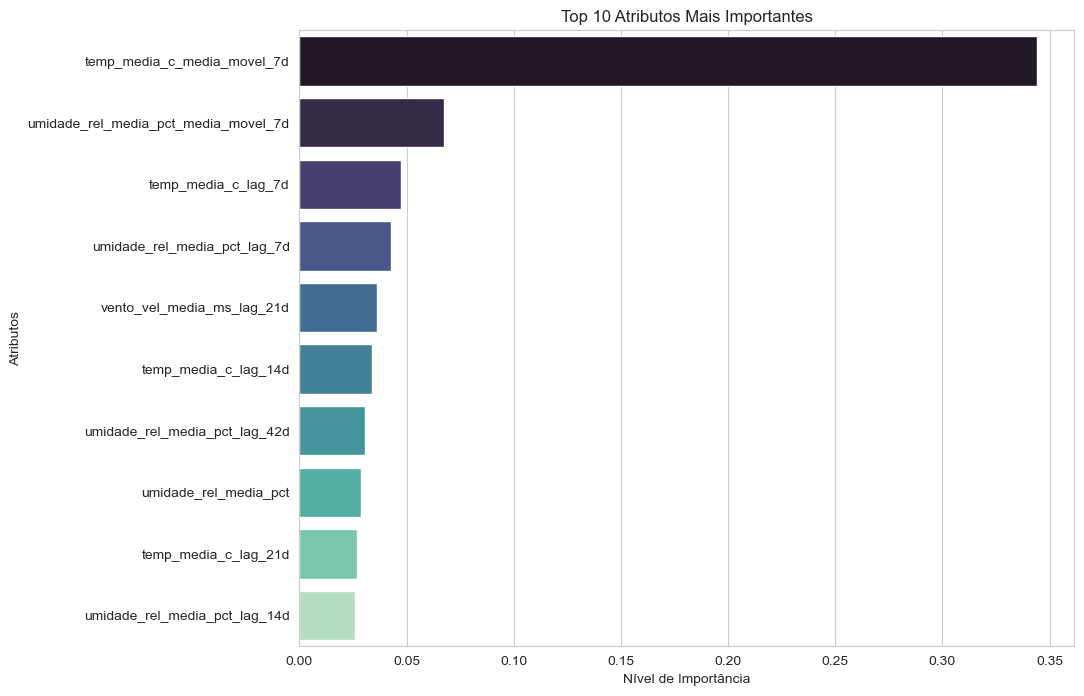

In [14]:
importancias = pd.Series(modelo.feature_importances_, index=X.columns)
importancias_top10 = importancias.nlargest(10)

plt.figure(figsize=(10, 8))
sns.barplot(x=importancias_top10, y=importancias_top10.index, palette='mako')
plt.title('Top 10 Atributos Mais Importantes')
plt.xlabel('Nível de Importância')
plt.ylabel('Atributos')
plt.show()